# 3D analysis open problem

In [99]:
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.datasets import MapDataset, Datasets
from gammapy.data import (
    DataStore,
    Observation,
    Observations,
)
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator
from gammapy.estimators.utils import find_peaks, find_peaks_in_flux_map
from gammapy.makers import (
    MapDatasetMaker, 
    SafeMaskMaker, 
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Model,
    Models,
)

In [2]:
# we need to set the path of the IRF:
%env CALDB=../caldb/

env: CALDB=../caldb/


In [3]:
data_store = DataStore.from_dir("../output")

In [4]:
#source coordinates
ra, dec = 257.500000 * u.deg, -46.0 * u.deg 
pointing = SkyCoord(ra, dec, frame="icrs")

In [5]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pointing.ra.deg,
    lat=pointing.dec.deg,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [6]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])
print(observations[0])

Observation

	obs id            : 5000002225 
 	tstart            : 61884.22
	tstop             : 61884.24
	duration          : 1575.00 s
	pointing (icrs)   : 255.2 deg, -43.8 deg

	deadtime fraction : 0.0%



Now, we generate the 'stacked' dataset:

In [7]:
energy_axis = MapAxis.from_energy_bounds(0.012, 100.0, 8, unit="TeV")

geom = WcsGeom.create(
    skydir=(pointing.ra.deg , pointing.dec.deg),
    binsz=0.01,
    width=(5, 5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.001, 40, 10, unit="TeV", name="energy_true"
)

In [8]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
)

In [9]:
offset_max = 6 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], offset_max=offset_max
)

maker_fov = FoVBackgroundMaker(method="scale")

In [10]:
for i, obs in enumerate(observations):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(observations)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 37, Background norm obs 5000002225: 1.24
1 of 37, Background norm obs 5000002226: 1.18
2 of 37, Background norm obs 5000002250: 1.13
3 of 37, Background norm obs 5000002251: 1.16
4 of 37, Background norm obs 5000002280: 1.22
5 of 37, Background norm obs 5000002307: 1.14
6 of 37, Background norm obs 5000002308: 1.47
7 of 37, Background norm obs 5000002404: 1.12
8 of 37, Background norm obs 5000002405: 1.07
9 of 37, Background norm obs 5000002436: 1.27
10 of 37, Background norm obs 5000002437: 1.68
11 of 37, Background norm obs 5000002459: 1.13
12 of 37, Background norm obs 5000002461: 1.08
13 of 37, Background norm obs 5000002635: 1.20
14 of 37, Background norm obs 5000002636: 1.08
15 of 37, Background norm obs 5000002652: 1.15
16 of 37, Background norm obs 5000002653: 1.13
17 of 37, Background norm obs 5000002666: 1.12
18 of 37, Background norm obs 5000002667: 2.53
19 of 37, Background norm obs 5000002723: 1.23
20 of 37, Background norm obs 5000002831: 1.36
21 of 37, Background no

Let's inspect the field:

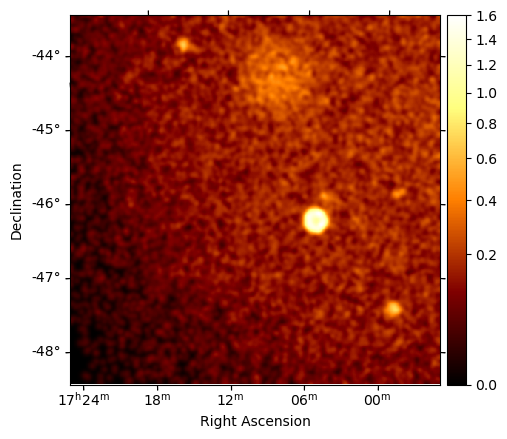

In [11]:
stacked.counts.sum_over_axes().smooth(0.03 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

In [12]:
stacked.counts.sum_over_axes().write("Gal_map.fits", overwrite=True)

In [13]:
stacked.background.plot_interactive(add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

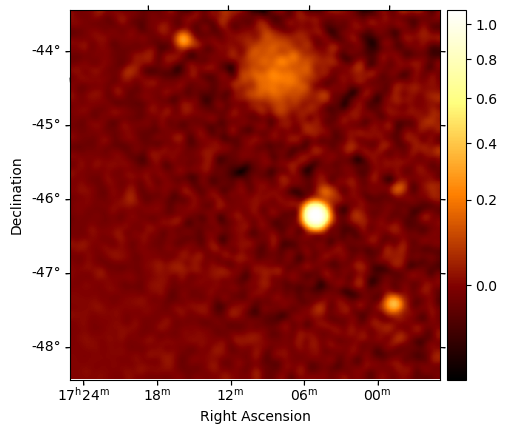

In [14]:
excess = stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

In [24]:
spatial_model = PointSpatialModel()

# We choose units consistent with the map units here...
spectral_model = PowerLawSpectralModel(amplitude="1e-22 cm-2 s-1 keV-1", index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

In [35]:
estimator = TSMapEstimator(
    model,
    kernel_width="0.5 deg",
    energy_edges=[0.03, 50] * u.TeV,
)
maps = estimator.run(stacked)

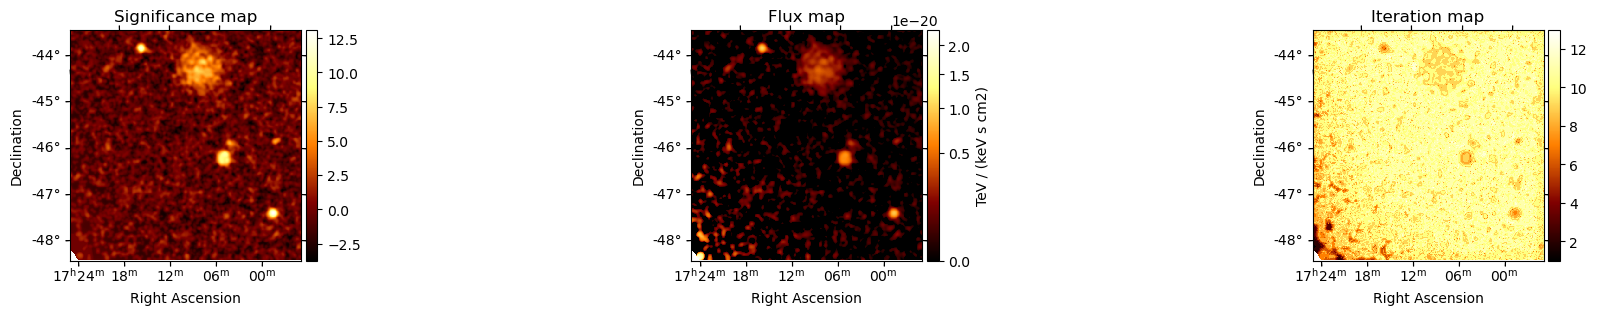

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(
    ncols=3,
    figsize=(20, 3),
    subplot_kw={"projection": stacked.counts.geom.wcs},
    gridspec_kw={"left": 0.1, "right": 0.98},
)

maps["sqrt_ts"].plot(ax=ax1, add_cbar=True)
ax1.set_title("Significance map")
maps["flux"].plot(ax=ax2, add_cbar=True, stretch="sqrt", vmin=0)
ax2.set_title("Flux map")
maps["niter"].plot(ax=ax3, add_cbar=True)
ax3.set_title("Iteration map")
plt.show()

value,x,y,ra,dec
,,,deg,deg
float64,int64,int64,float64,float64
13.139,438,101,254.71273,-47.45202
12.163,153,458,258.83858,-43.90689
10.184,333,228,256.29337,-46.20868
7.9217,287,428,256.97705,-44.21377
7.8171,273,411,257.17130,-44.38452
6.3023,344,253,256.14061,-45.95694
5.8241,442,256,254.73322,-45.90157


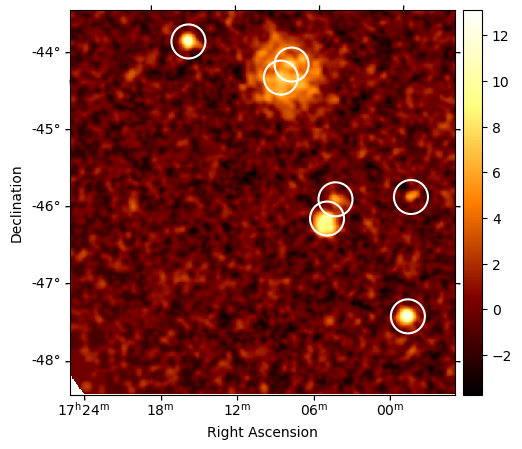

In [38]:
sources = find_peaks(maps["sqrt_ts"], threshold=5, min_distance="0.15 deg")
nsou = len(sources)
display(sources)

# Plot sources on top of significance sky image
plt.figure(figsize=(9, 5))
ax = maps["sqrt_ts"].plot(add_cbar=True)

ax.scatter(
    sources["ra"],
    sources["dec"],
    transform=ax.get_transform("icrs"),
    color="none",
    edgecolor="w",
    marker="o",
    s=600,
    lw=1.5,
)
plt.show()

# sphinx_gallery_thumbnail_number = 3

In [67]:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)
bkg_model.spectral_model.norm.value = 1.0
    
models_stacked = Models([bkg_model])

In [68]:
for i, src in enumerate(sources):
    print(f"- Analysis of the source {i+1}...")

    spectral_model = PowerLawSpectralModel(
    index=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
            )
    
    spatial_model = GaussianSpatialModel(
    lon_0=src["ra"] * u.deg, lat_0=src["dec"] * u.deg, frame="icrs",
    sigma="0.1 deg"
            )

    model = SkyModel(
        spatial_model=spatial_model,
        spectral_model=spectral_model,
        name=f"src_{i}",
            )

    models_stacked.extend(Models([model]))
    
    stacked.models = models_stacked

    stacked.models[-1].parameters["lon_0"].frozen = True
    stacked.models[-1].parameters["lat_0"].frozen = True

    fit = Fit(optimize_opts={"print_level": 1})
    result = fit.run(datasets=[stacked])
    print(result)
    print(f"   * Analysis of the source {i+1}... complete!")

#    for n in stacked.models[-1].parameters.names:
#        stacked.models[-1].parameters[n].frozen = True


- Analysis of the source 1...
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 132
	total stat : 260106.59

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

   * Analysis of the source 1... complete!
- Analysis of the source 2...


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/modeling/models/spatial.py:654: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Iterations finish without convergence; Edm 1.94421 Requested 0.0002
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 377
	total stat : 259934.19

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

   * Analysis of the source 2... complete!
- Analysis of the source 3...


/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/astropy/units/quantity.py:666: RuntimeWarning: divide by zero encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/fabiopintore/opt/anaconda3/envs/gammapy-1.2/lib/python3.10/site-packages/gammapy/modeling/models/spatial.py:654: RuntimeWarning: invalid value encountered in multiply
  return u.Quantity(norm * np.exp(exponent).value, "sr-1", copy=False)


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1106
	total stat : 259110.43

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

   * Analysis of the source 3... complete!
- Analysis of the source 4...
W MnPosDef non-positive diagonal element in covariance matrix[ 6 ] = -2.19063e-05
W MnPosDef Added to diagonal of Error matrix a value 0.500023
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 727
	total stat : 258217.93

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

   * Analysis of the source 4... complete!
- Analysis of the source 5...
OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated su

In [69]:
print(stacked.models)

DatasetModels

Component 0: FoVBackgroundModel

  Name                      : my-dataset-bkg
  Datasets names            : ['my-dataset']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      0.939   +/-    0.01             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         

Component 1: SkyModel

  Name                      : src_0
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : GaussianSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.023   +/-    0.09             
    amplitude                     :   5.48e-13   +/- 9.1e-14 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lon_0                 (frozen):    254.713       deg         
    lat_0                 (frozen):    -47.452       deg    

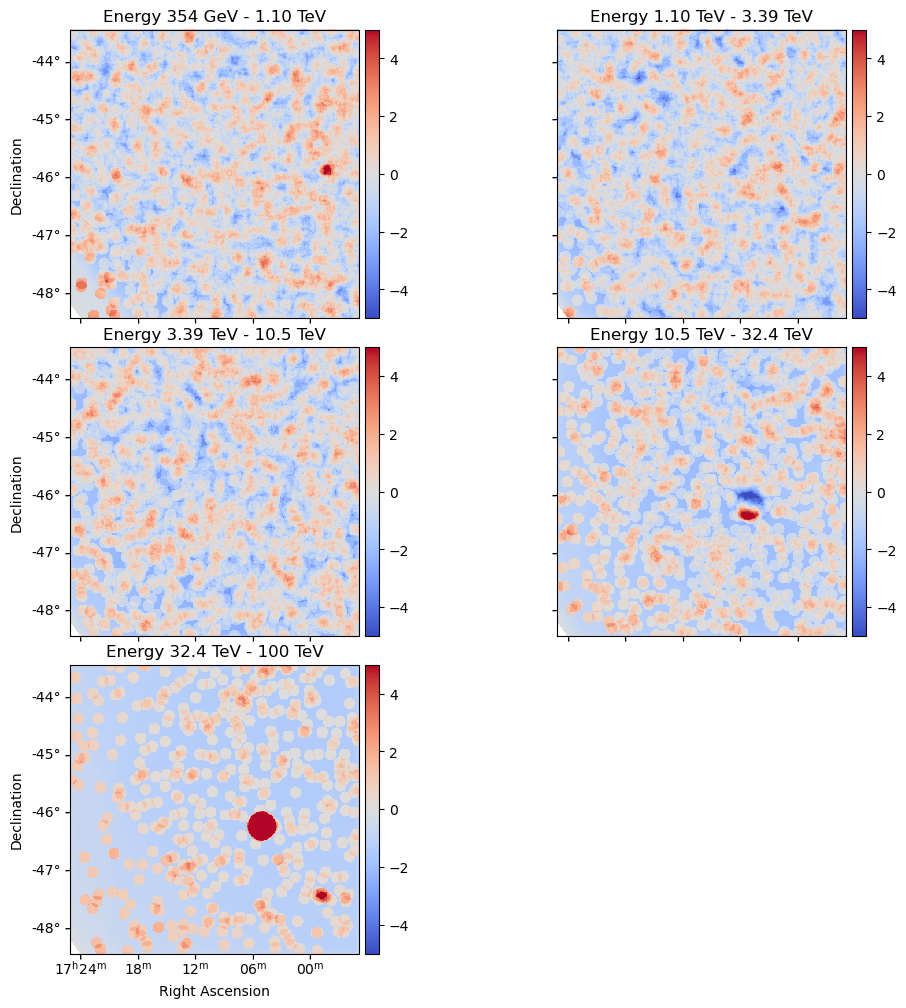

In [70]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.3, 1, 5, 10, 20, 100] * u.TeV,
)

result = estimator.run(stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 12), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)
plt.show()

In [96]:
ra, dec, index, amplitude, sigma = [], [], [], [], []
for mod in stacked.models[1:]:
    ra.append(mod.spatial_model.lon_0.value) 
    dec.append(mod.spatial_model.lat_0.value) 
    index.append(mod.spectral_model.index.value) 
    amplitude.append(mod.spectral_model.amplitude.value) 
    sigma.append(mod.spatial_model.sigma.value) 

In [103]:
catalogue = Table()
catalogue["Ra"] = ra * u.deg
catalogue["Dec"] = dec * u.deg
catalogue["Amplitude"] = amplitude  * u.cm**-2 * u.s**-1 * u.TeV**-1
#catalogue["Amplitude_err"]
catalogue["Index"] = index
#catalogue["Index_err"]
catalogue["sigma"] = sigma * u.deg
#catalogue["sigma_err"]

print(catalogue)

        Ra                 Dec                Amplitude               Index                 sigma         
       deg                 deg             1 / (TeV s cm2)                                   deg          
------------------ ------------------- ----------------------- -------------------- ----------------------
254.71273338535195  -47.45201811867892   5.476444210624122e-13     2.02349658596679     0.0458425110578946
 258.8385794398773  -43.90689126201961   6.370862267776765e-13   3.3304052912784403 3.1906876493385354e-05
 256.2933736953403 -46.208675279829606   3.884742369454746e-15 -0.28441824178260466    0.09903983715978198
256.97705030438004  -44.21376895847112  1.1976263887532913e-12    1.871634078639111    0.29705644289367233
 257.1713028473741 -44.384515107695734  2.8722228247816834e-12    2.055442316576175     0.2847782778524492
256.14061101842196   -45.9569358663143  2.5596422319000853e-13   2.7133931678327987    0.03140478927604744
254.73321780871615  -45.9015658695680